# RESOLVE Data Tutorial
This jupyter notebook illustrates use of the public RESOLVE (REsolved Spectroscopy Of a Local VolumE) survey database, including HI upper limit and confusion information. As of this writing, the HI mass census is fully available (Stark et al. 2016), but HI profile metrics are still being analyzed. The optical spectroscopic census is ~70% complete and is still being reduced and analyzed.<br/>

Note that the RESOLVE catalog and all calculations below assume $H_0$ = 70 km/s/Mpc, implying a combined volume for RESOLVE-A and RESOLVE-B of 52,135 cubic Mpc. Also, the halo abundance matching algorithm used by Eckert et al. (2016, 2017) and Stark et al. (2016) used the Warren et al. (2006) halo mass function, implying halo masses on an M280b scale. M280b ~ M200c + 0.1 for concentration ~5.<br/>

The RESOLVE website at http://resolve.astro.unc.edu/ provides further information, data, and links to papers as well as details on the ECO (Environmental COntext) catalog. ECO is a nearly ten times larger data set surrounding RESOLVE with comparable photometric and environmental data, but it has no new radio or optical spectroscopy beyond SDSS/ALFALFA. A follow-up tutorial demonstrating the use of ECO to correct for cosmic variance in RESOLVE (in the spirit of Eckert et al. 2016) will be provided soon, along with a forthcoming analysis of the bivariate HI mass function comparing RESOLVE and the Simba simulation (Kannappan, Davé, Eckert, et al., in prep.) -- check for updates at the RESOLVE website!

Author: Sheila Kannappan<br/>
Created: August 2019 (revised by Z. Hutchens in May 2021)

### Preliminaries

In [1]:
# standard imports and naming conventions; uncomment as needed
import numpy as np              # basic numerical analysis
import matplotlib.pyplot as plt # plotting
import matplotlib as mp
import pred_loggs_dist as pgf # code from Eckert, K.+ 2015 (https://github.com/keckert7/codes)

%matplotlib inline

The RESOLVE DR4 csv file is provided in the same github repo as this jupyter notebook, and the README provides instructions to retrieve it. If you wish to obtain a different data release, visit the RESOLVE "searchable database" page [here](http://resolve.astro.unc.edu/pages/database.php), which includes all data releases as well as sample sql queries. The simplest possible query, `select *`, will retrieve an entire database (before clicking submit, be sure to switch the output choice from "browse the results of the query" to "download the results of the query (CSV)"). The [same page](http://resolve.astro.unc.edu/pages/database.php) provides a glossary for each data release. Open the glossary matching the data release you are using in a separate tab.

In [2]:
# next read in RESOLVE DR4 csv file, assuming it is in the same directory as this jupyter notebook
# (try alternate syntax below if you get an error message regarding encoding)
#data = np.genfromtxt("RESOLVE_DR4_accepted.csv", delimiter=",", dtype=None, names=True)
data = np.genfromtxt("RESOLVE_DR4_accepted.csv", delimiter=",", dtype=None, names=True, encoding=None)

If you want to look at the column names, type `data.dtype.names`, but they should match the glossary [here](http://resolve.astro.unc.edu/pages/database.php) except for possible capitalization differences.

### Sample Selection

The RESOLVE database includes galaxies that are not officially part of the survey. They may either have redshifts in the buffer range used for group-finding or have magnitudes fainter than the survey luminosity floor. In some cases data for these galaxies may be useful, but please do not expect all of it to be carefully vetted. We recommend working with one of the following sample definitions to isolate complete, high-quality data sets:<br/><br/>
1) the original luminosity- and volume-limited sample: brighter than -17.33 (A-semester) or -17.0 (B-semester) with Grpcz between 4500-7000 km/s<br/>
2) the observational sample (for new 21cm and optical spectroscopy): same as #1, but adding in galaxies with known or estimated log(M\*+1.4MHI)> 9.2 (A-semester) or 9.0 (B-semester) <br/>
3) the baryonic mass complete sample: Grpcz between 4500-7000 km/s and log Mbary> 9.3 (A-semester) or 9.1 (B-semester), where Mbary = (M\*+1.4MHI)<br/>
4) the stellar mass complete sample: Grpcz between 4500-7000 km/s and log M\*> 8.9 (A-semester) or 8.7 (B-semester)<br/><br/>
**NOTE 1:** Eckert et al. (2016, 2017) adopted higher baryonic mass completeness limits: log Mbary> 9.4 (for ECO containing RESOLVE-A) and log Mbary> 9.1 (for RESOLVE-B); note however that RESOLVE-A is more complete than ECO as a whole <br/>
**NOTE 2:** To simplify analysis, Stark et al. (2016) adopted a common floor for both RESOLVE-A and RESOLVE-B: log M\* > 8.9 and log Mbary > 9.3<br/>

### We will first select the original luminosity-complete data set (\#1 above).


In [3]:
grpcz = data['g3grpcz']
invol = (grpcz >= 4500) & (grpcz < 7000)
fl_insample = data['fl_insample'] # flag for original luminosity limits as in #1 above
inorigsample = invol & fl_insample
incatalog = (grpcz != 0)
ngal = np.sum(incatalog)
print("in catalog %i" % ngal)
print("in sample %i" % np.sum(inorigsample))

in catalog 2289
in sample 1458


### Before looking at the HI data, let's examine the stellar mass, color, and environment properties of this sample.

In [4]:
logmstar = data['logmstar']
urcolor = data['modelur']
urcolorcorr = data['modelurcorr'] # internal extinction-corrected, useful for sequence separation
logmhalo = data['g3logmhvir'] # use the groups/halo masses defined for the luminosity-limited sample
fc = data['g3fc'] # central/satellite flag (1/0)
cent = (fc == 1)
sat = (fc == 0)

In [5]:
#optionally test that these quantities are valid for all original sample galaxies
#print(np.sum(logmstar[np.where(inorigsample)] > 0))
#print(np.sum(urcolorcorr[np.where(inorigsample)] > 0))
#print(np.sum(logmhalo[np.where(inorigsample)] > 0))

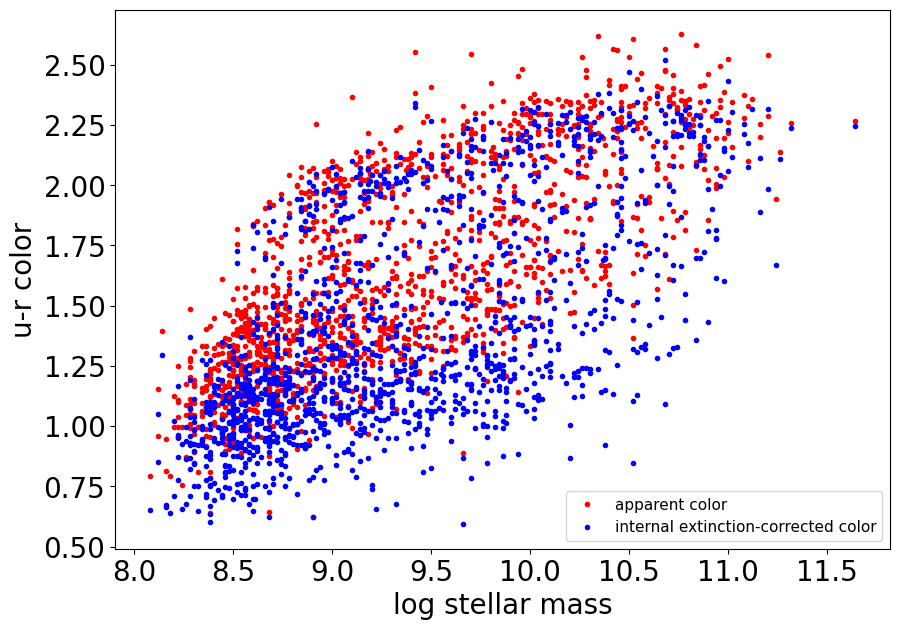

In [6]:
font = {'size' : 20}
mp.rc('font', **font)
fig1 = plt.figure(1,figsize=(10,7))
plt.clf()
plt.plot(logmstar[np.where(inorigsample)],urcolor[np.where(inorigsample)],'r.', label="apparent color")
plt.plot(logmstar[np.where(inorigsample)],urcolorcorr[np.where(inorigsample)],'b.', label="internal extinction-corrected color")
plt.xlabel("log stellar mass")
plt.ylabel("u-r color")
plt.legend(loc="best",fontsize=11)
plt.show()

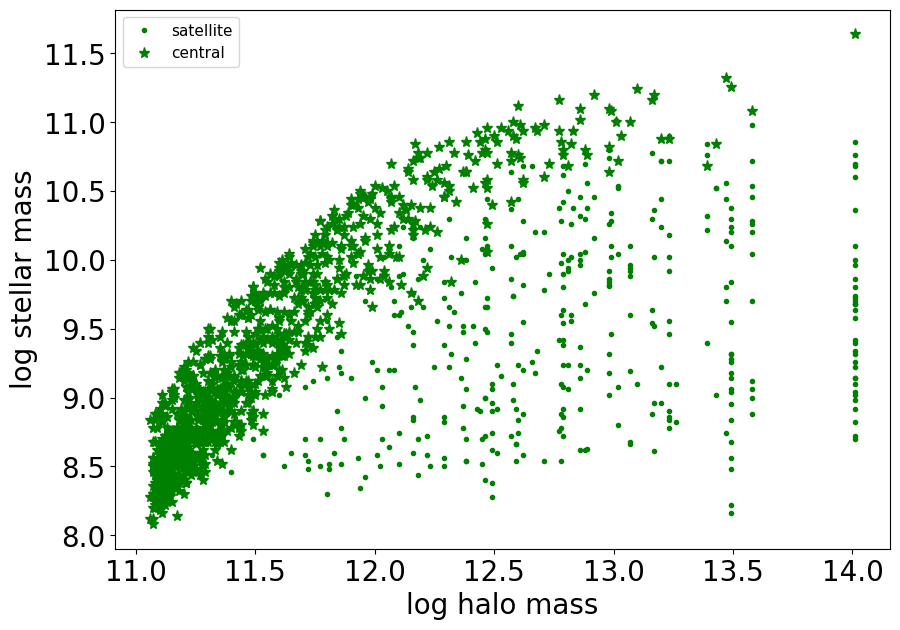

centrals: 1060
satellites: 398


In [7]:
fig2 = plt.figure(2,figsize=(10,7))
plt.clf()
plt.plot(logmhalo[np.where(inorigsample & sat)],logmstar[np.where(inorigsample & sat)],'g.', label="satellite")
plt.plot(logmhalo[np.where(inorigsample & cent)],logmstar[np.where(inorigsample & cent)],'g*', markersize=8, label="central")
plt.xlabel("log halo mass")
plt.ylabel("log stellar mass")
plt.legend(loc="best",fontsize=11)
plt.show()
print("centrals: %i" % np.sum(cent[np.where(inorigsample)]))
print("satellites: %i" % np.sum(sat[np.where(inorigsample)]))

This figure serves as a useful reminder that contrary to our intuition, *most galaxies are centrals*. This follows from the steeply rising mass function of parent dark matter halos: at any halo mass, there are many more parent halos than subhalos of higher-mass halos, even though those subhalos obviously outnumber their parent halos.

### Now let's tackle the HI data. Skip straight to "The Optimal Combination" if you just want "the answer" -- the next several cells show what's under the hood.

Note: HI mass values in the `mhidet`, `mhilim`, and `emhidet` columns are computed using a distance $D=(\frac{cz}{H_0})^2$, assuming $H_0 = 70$ km/s/Mpc. To remove the fingers-of-god effect, we will scale these so that the HI masses are based on mean group redshifts. 

In [8]:
hitelescope = data['hitelescope']
mhidet = data['mhidet']*(data['g3grpcz']/data['cz'])**2.0
emhidet = data['e_mhidet']*(data['g3grpcz']/data['cz'])**2.0
mhilim = data['mhilim']*(data['g3grpcz']/data['cz'])**2.0
emhidet[np.where(emhidet==0)] = np.nan

# Compute SNR for 21cm detections
notmissing = np.where(~np.isnan(emhidet))
snr21 = np.zeros(ngal)
snr21[notmissing] = mhidet[notmissing]/emhidet[notmissing] # equal to fhi/efhi

# first let's see where we started (with ALFALFA)

sel1 = np.where(inorigsample & (hitelescope == "ALFALFA") & (snr21 >= 5) & (mhidet>0)) # note 5 not 6.5
sel2 = np.where(inorigsample & (hitelescope == "ALFALFA") & (snr21 < 5) & (snr21 > 0) & (mhidet>0))
sel3 = np.where(inorigsample & (hitelescope == "ALFALFA") & (mhilim>0))
hitostars1 = (mhidet[sel1]) / (10**logmstar[sel1]) # strong detections
hitostars2 = (mhidet[sel2]) / (10**logmstar[sel2]) # weaker detections
hitostars3 = (mhilim[sel3]) / (10**logmstar[sel3]) # upper limits
print(len(sel1[0]))
print(len(sel2[0]))
print(len(sel3[0]))

669
6
98


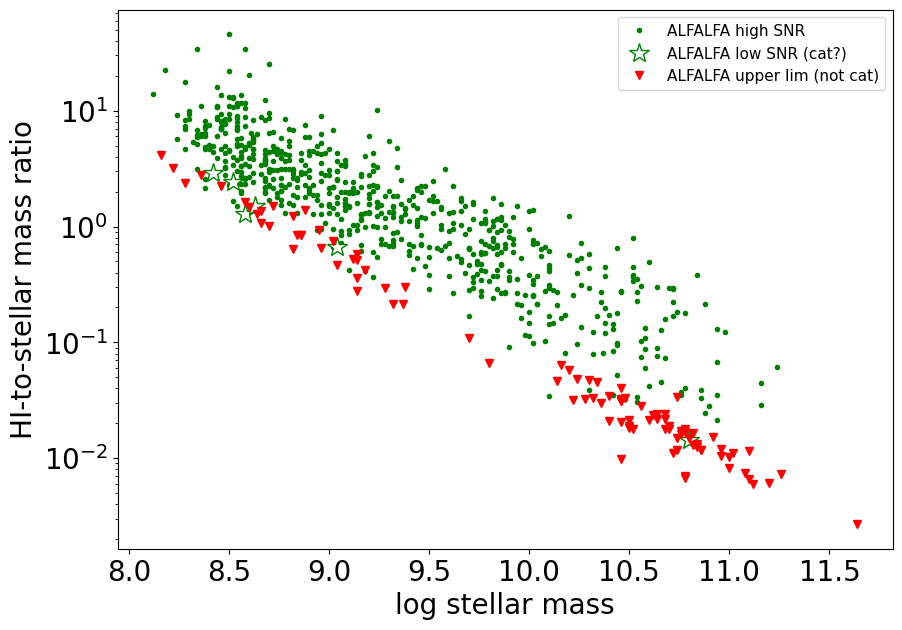

In [9]:
fig2 = plt.figure(2,figsize=(10,7))
plt.clf()
plt.plot(logmstar[sel1],hitostars1,'g.', label="ALFALFA high SNR")
plt.plot(logmstar[sel2],hitostars2,'g*', markersize=15, markerfacecolor="white", label="ALFALFA low SNR (cat?)")
plt.plot(logmstar[sel3],hitostars3,'rv', label="ALFALFA upper lim (not cat)")
plt.yscale('log')
plt.xlabel("log stellar mass")
plt.ylabel("HI-to-stellar mass ratio")
plt.legend(loc="best",fontsize=11)
plt.show()

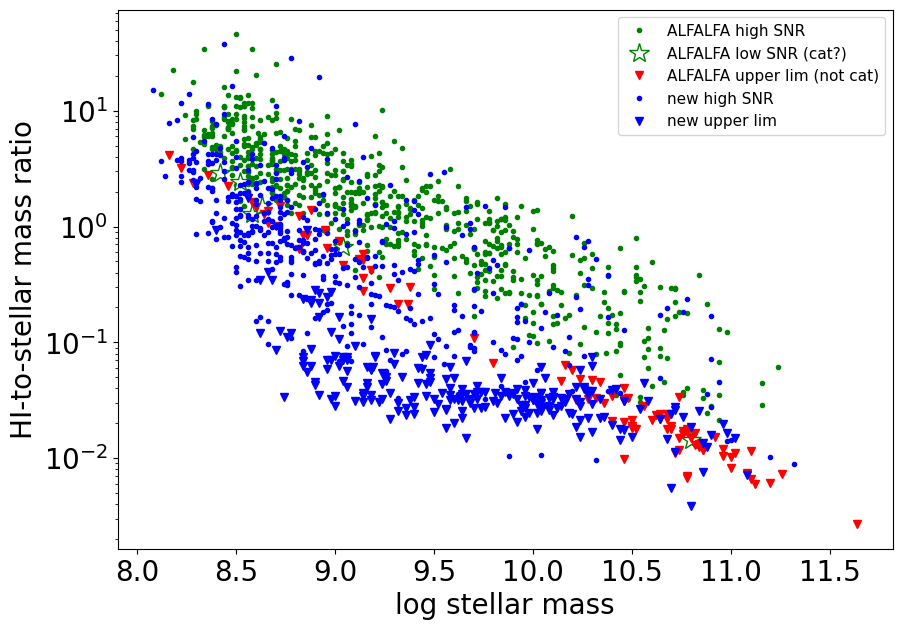

444
237


In [10]:
# add new data (detections and upper limits separately)
sel4 = np.where(inorigsample & (hitelescope != "ALFALFA") & (mhidet>0) & (~np.isnan(emhidet))) # again, not missing
hitostars4 = (mhidet[sel4]) / (10**logmstar[sel4])
sel5 = np.where(inorigsample & (hitelescope != "ALFALFA") & (mhilim>0))
hitostars5 = (mhilim[sel5]) / (10**logmstar[sel5])

# repeat plot
fig3 = plt.figure(3,figsize=(10,7))
plt.clf()
plt.plot(logmstar[sel1],hitostars1,'g.', label="ALFALFA high SNR")
plt.plot(logmstar[sel2],hitostars2,'g*', markersize=15, markerfacecolor="white", label="ALFALFA low SNR (cat?)")
plt.plot(logmstar[sel3],hitostars3,'rv', label="ALFALFA upper lim (not cat)")
plt.yscale('log')
plt.xlabel("log stellar mass")
plt.ylabel("HI-to-stellar mass ratio")
# add new data to plot
plt.plot(logmstar[sel4],hitostars4,'b.', label="new high SNR")
plt.plot(logmstar[sel5],hitostars5,'bv', label="new upper lim")
plt.legend(loc="best",fontsize=11)
plt.show()

print(len(sel4[0]))
print(len(sel5[0]))

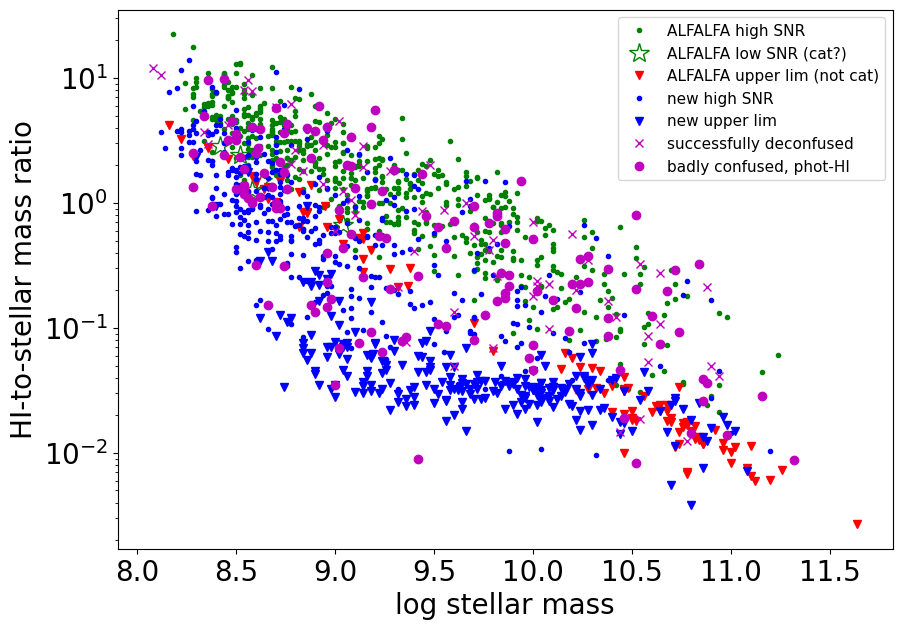

59
133
192
0


In [11]:
# replace confused detections with successfully deconfused data
confused = data['confused']
mhicorr = data['mhi_corr']*(data['g3grpcz']/data['cz'])**2. # deconfused flux, correct for group velocity
emhicorr_rand = data['emhi_corr_rand']*((data['g3grpcz']/data['cz'])**2.) # random error on deconfused HI mass
emhicorr_sys = data['emhi_corr_sys']*(data['g3grpcz']/data['cz'])**2. # systematic error on deconfused HI mass

mhicorr[np.where(mhicorr == 0)] = np.nan # treat zero in f21corr as NaN
notempty = np.where(~np.isnan(mhicorr))
deconfokay = np.zeros(ngal,dtype=bool)
deconfokay[notempty] = ((emhicorr_sys[notempty]/mhicorr[notempty]) < 0.25) & (mhicorr[notempty]<=mhidet[notempty])
goodconf = (confused == 1) & deconfokay # successfully deconfused
badconf = (confused == 1) & ~deconfokay # unsuccessfully deconfused

notconf = (confused != 1)
sel1b = np.where(inorigsample & (hitelescope == "ALFALFA") & (snr21 >= 5) & (mhidet>0) & notconf) # note 5 not 6.5
sel2b = np.where(inorigsample & (hitelescope == "ALFALFA") & (snr21 < 5) & (snr21 > 0) & (mhidet>0) & notconf)
sel3b = np.where(inorigsample & (hitelescope == "ALFALFA") & (mhilim>0) & notconf) # notconf is unnecessary here
sel4b = np.where(inorigsample & (hitelescope != "ALFALFA") & (mhidet>0) & (~np.isnan(emhidet)) & notconf) # again, not missing
sel5b = np.where(inorigsample & (hitelescope != "ALFALFA") & (mhilim>0) & notconf) # notconf is unnecessary here
hitostars1b = (mhidet[sel1b]) / (10**logmstar[sel1b])
hitostars2b = (mhidet[sel2b]) / (10**logmstar[sel2b])
hitostars3b = (mhilim[sel3b]) / (10**logmstar[sel3b])
hitostars4b = (mhidet[sel4b]) / (10**logmstar[sel4b])
hitostars5b = (mhilim[sel5b]) / (10**logmstar[sel5b])

sel6 = np.where(inorigsample & goodconf)
hitostars6 = (mhicorr[sel6]) / (10**logmstar[sel6])

# will need photometric gas fractions for unsuccessfully deconfused galaxies
modeluj = data['modeluj']
b_a=data['axialratio']
modcolor = 1.140*modeluj + 0.594*(b_a) # from Eckert et al (2015) -- 1D fit with survival analysis on Mgas-to-M* limits
photloggovers = 3.659 -0.981*modcolor # from Eckert et al (2015) volume-limited calibration, ~0.3 dex scatter
logmhiphot = np.log10((10**photloggovers/1.4) * 10**logmstar) # take out 1.4 for Helium --> just HI

sel7 = np.where(inorigsample & badconf)
hitostars7 = (np.minimum(10**logmhiphot[sel7],mhidet[sel7])) / (10**logmstar[sel7])
# above says phot-gas cannot exceed measured total

# repeat plot replacing confused data with deconfused data or photometric estimates
fig4 = plt.figure(4,figsize=(10,7))
plt.clf()
plt.plot(logmstar[sel1b],hitostars1b,'g.', label="ALFALFA high SNR")
plt.plot(logmstar[sel2b],hitostars2b,'g*', markersize=15, markerfacecolor="white", label="ALFALFA low SNR (cat?)")
plt.plot(logmstar[sel3b],hitostars3b,'rv', label="ALFALFA upper lim (not cat)")
plt.plot(logmstar[sel4b],hitostars4b,'b.', label="new high SNR")
plt.plot(logmstar[sel5b],hitostars5b,'bv', label="new upper lim")
plt.plot(logmstar[sel6],hitostars6,'mx', markersize=6, label="successfully deconfused")
plt.plot(logmstar[sel7],hitostars7,'mo', markersize=6, label="badly confused, phot-HI")
plt.yscale('log')
plt.xlabel("log stellar mass")
plt.ylabel("HI-to-stellar mass ratio")
plt.legend(loc="best",fontsize=11)
plt.show()

print(len(sel6[0]))
print(len(sel7[0]))
print(np.sum((confused == 1) & inorigsample))
print(np.sum((logmhiphot <= 0)))

## The Optimal Combination
The cell below combines the HI data for the entire catalog, without reference to a specific subsample until the plot selection commands.

**Note**: If you use RESOLVE HI data as described below, please cite Eckert et al. (2015), Stark et al. (2016), and Eckert et al. (2016), respectively, for (i) the photometric gas fraction calibration and code, (ii) the HI data, and (iii) the dividing values used for incorporation of upper limit/confused data. Of course, you may choose to differ from (iii) in which deconfused values you consider acceptable and/or which upper limits you consider strong.

In [12]:
combinedmhi = mhidet+mhilim # combine upper limits and detections
combinedmhi[(combinedmhi==0)]=1. # where unobserved, set combinedmhi = 1 Msun to avoid log errors
logmhi = np.log10(combinedmhi)
bestlogmhi = logmhi.copy() # combine limits and detections

#################################################################
#################################################################
# sub in successfully deconfused data
bestlogmhi[np.where(goodconf)] = np.log10(mhicorr[np.where(goodconf)])
# use *constrained* phot-gas for unsuccessfuly-deconfused upper limit data
#2D distribution of G/S
calibration = 11
pars = pgf.getpars(calibration)
ploton = 0
loggsvals,p_loggs = pgf.estimategovers(modcolor,pars,ploton)
# loggsvals = np.arange(-2,2.04,0.04) so 101 edges of 100 bins from -2 to +2
# p_loggs is normalized to sum to 1 so is implicitly per 0.04 dex

thresh=0.1
badcount = np.sum((badconf) & ((1.4*mhidet/10**logmstar) > thresh))
badind = (np.where(badconf & ((1.4*mhidet/10**logmstar) > thresh)))[0]
renorms = np.zeros(badcount)
for j in range(badcount):
    if badconf[badind[j]]: #renormalize probability distribution to reflect measured total
        lmhi_j = loggsvals - np.log10(1.4) + logmstar[badind[j]] # convert G/S tick marks to HI mass tick marks
        p_loggs[np.where(lmhi_j >= logmhi[badind[j]]), badind[j]] = 0 # set probability distribution to 0 above observed measured total
        renorms[j] = np.sum(p_loggs[np.where(lmhi_j < logmhi[badind[j]]),badind[j]])
        p_loggs[np.where(lmhi_j < logmhi[badind[j]]),badind[j]] = p_loggs[np.where(lmhi_j < logmhi[badind[j]]),badind[j]] / renorms[j]
        cum_p_loggs = np.cumsum(p_loggs,axis=0)
        logmhiphot[badind[j]] = np.interp(0.5,cum_p_loggs[:,badind[j]],lmhi_j) # take median of remaining distribution
    else:
        print("This should NEVER happen")
bestlogmhi[(badind)] = logmhiphot[(badind)]
bestlogmhi[np.where((badconf) & ~((1.4*mhidet/10**logmstar) > thresh) & ~np.isnan(mhicorr) & (mhicorr<=mhidet))] = np.log10(mhicorr[np.where((badconf) & ~((1.4*mhidet/10**logmstar) > thresh) & ~np.isnan(mhicorr) & (mhicorr<=mhidet))])
bestlogmhi[np.where((badconf) & ~((1.4*mhidet/10**logmstar) > thresh) & ~np.isnan(mhicorr) & (mhicorr>mhidet))] = np.log10(mhidet[np.where((badconf) & ~((1.4*mhidet/10**logmstar) > thresh) & ~np.isnan(mhicorr) & (mhicorr>mhidet))]) # mhicorr bad in this case
bestlogmhi[np.where((badconf) & ~((1.4*mhidet/10**logmstar) > thresh) & np.isnan(mhicorr))] = np.log10(mhidet[np.where((badconf) & ~((1.4*mhidet/10**logmstar) > thresh) & np.isnan(mhicorr))])



#################################################################
#################################################################
# use phot-gas for missing data
missing = (logmhi==0) #np.isnan(logmhi)
bestlogmhi[np.where(missing)] = logmhiphot[np.where(missing)]

#################################################################
#################################################################
# use *constrained* phot-gas for weak upper limit data
weaklimit = np.zeros(ngal,dtype=bool)
weaklimit[np.where(mhilim>0)] =  (1.4 * 10**logmhi[np.where(mhilim>0)])/(10**logmstar[np.where(mhilim>0)]) > 0.05
# choice of 0.05 follows Eckert et al. 2016 with 1.4 for Helium correction, could make less strict
#2D distribution of G/S
calibration = 11
pars = pgf.getpars(calibration)
ploton = 0
loggsvals,p_loggs = pgf.estimategovers(modcolor,pars,ploton)
# loggsvals = np.arange(-2,2.04,0.04) so 101 edges of 100 bins from -2 to +2
# p_loggs is normalized to sum to 1 so is implicitly per 0.04 dex
limcount = np.sum(mhilim>0)
limind = (np.where(mhilim>0))[0]
renorms = np.zeros(limcount)
for j in range(limcount): 
    if weaklimit[limind[j]]: #renormalize probability distribution to reflect upper limit
        lmhi_j = loggsvals - np.log10(1.4) + logmstar[limind[j]] # convert G/S tick marks to HI mass tick marks
        p_loggs[np.where(lmhi_j >= logmhi[limind[j]]), limind[j]] = 0 # set probability distribution to 0 above observed limit
        renorms[j] = np.sum(p_loggs[np.where(lmhi_j < logmhi[limind[j]]),limind[j]])
        p_loggs[np.where(lmhi_j < logmhi[limind[j]]),limind[j]] = p_loggs[np.where(lmhi_j < logmhi[limind[j]]),limind[j]] / renorms[j]
        cum_p_loggs = np.cumsum(p_loggs,axis=0)
        logmhiphot[limind[j]] = np.interp(0.5,cum_p_loggs[:,limind[j]],lmhi_j) # take median of remaining distribution
    else: # this limit is so strong, might as well treat it as a number
        logmhiphot[limind[j]] = logmhi[limind[j]] # unused assignment for clarity, strong limits already set to logmhi
bestlogmhi[np.where(weaklimit)] = logmhiphot[np.where(weaklimit)]

stronglimit = (mhilim>0) & ~weaklimit
fakedata = badconf | missing | weaklimit

logmbary = np.log10(10**logmstar + 1.4*(10**bestlogmhi)) # bringing back the Helium correction
besthitostars = (10**bestlogmhi) / (10**logmstar)

Note that the above "optimal combination" treats strong upper limits as if they were measurements. Another option would be to use survival analysis to model them; the choice depends on your science.

1458


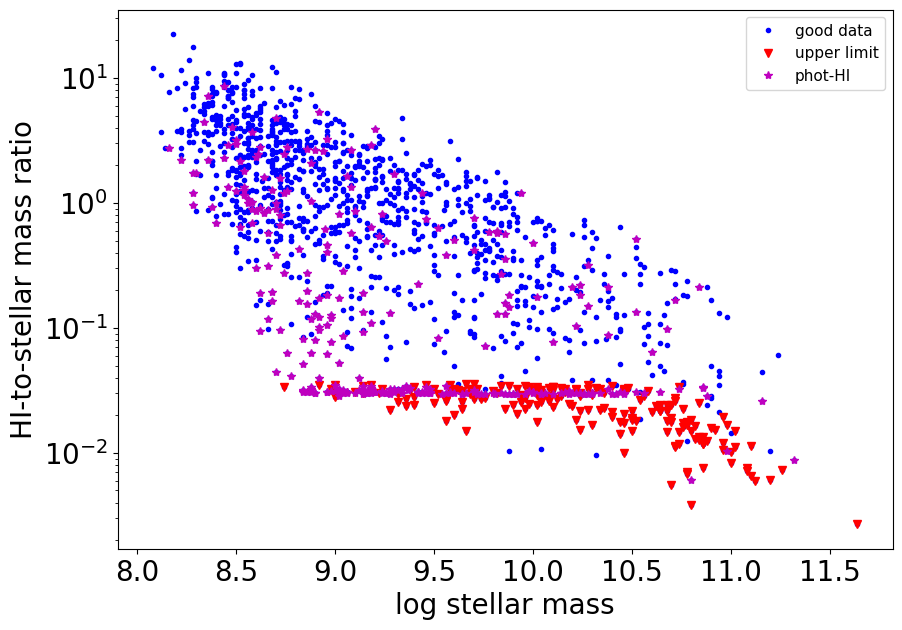

In [13]:
# plot results based on the above bestlogmhi and besthitostars

# try running this cell with different options for sample:
#insample = incatalog
insample = inorigsample # luminosity limited
#insample = (logmbary > 9.3) # baryonic mass limited, ignoring extra depth in RESOLVE-B
#insample = (logmstar > 8.9) # stellar mass limited, ignoring extra depth in RESOLVE-B

print(np.sum(insample))

selall = np.where(insample)
sellim = np.where(insample & stronglimit)
selfake = np.where(insample & fakedata)

fig5 = plt.figure(5,figsize=(10,7))
plt.clf()
plt.plot(logmstar[selall],besthitostars[selall],'b.', label="good data")
plt.plot(logmstar[sellim],besthitostars[sellim],'rv', label="upper limit")
plt.plot(logmstar[selfake],besthitostars[selfake],'m*', label="phot-HI")
plt.yscale('log')
plt.xlabel("log stellar mass")
plt.ylabel("HI-to-stellar mass ratio")
plt.legend(loc="best",fontsize=11)
plt.show()

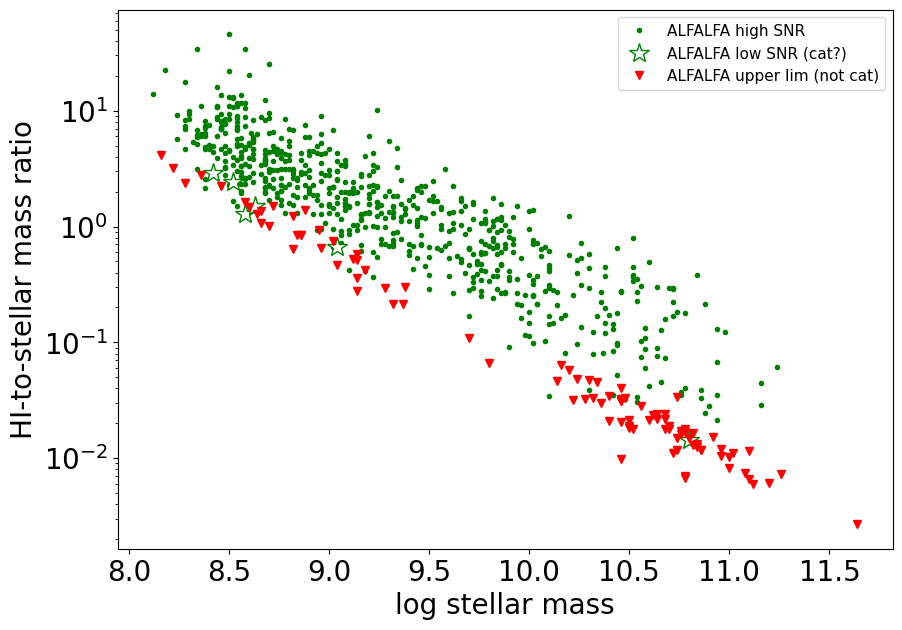

In [14]:
# compare to the original
fig2 = plt.figure(2,figsize=(10,7))
plt.clf()
plt.plot(logmstar[sel1],hitostars1,'g.', label="ALFALFA high SNR")
plt.plot(logmstar[sel2],hitostars2,'g*', markersize=15, markerfacecolor="white", label="ALFALFA low SNR (cat?)")
plt.plot(logmstar[sel3],hitostars3,'rv', label="ALFALFA upper lim (not cat)")
plt.yscale('log')
plt.xlabel("log stellar mass")
plt.ylabel("HI-to-stellar mass ratio")
plt.legend(loc="best",fontsize=11)
plt.show()

### As an r-band selected survey, RESOLVE is most naturally baryonic mass limited (r-band luminosity correlates more tightly with baryonic mass than stellar mass; Kannappan et al. 2013). Below is a plot as a function of baryonic rather than stellar mass, showing all galaxies in the original luminosity-complete sample.

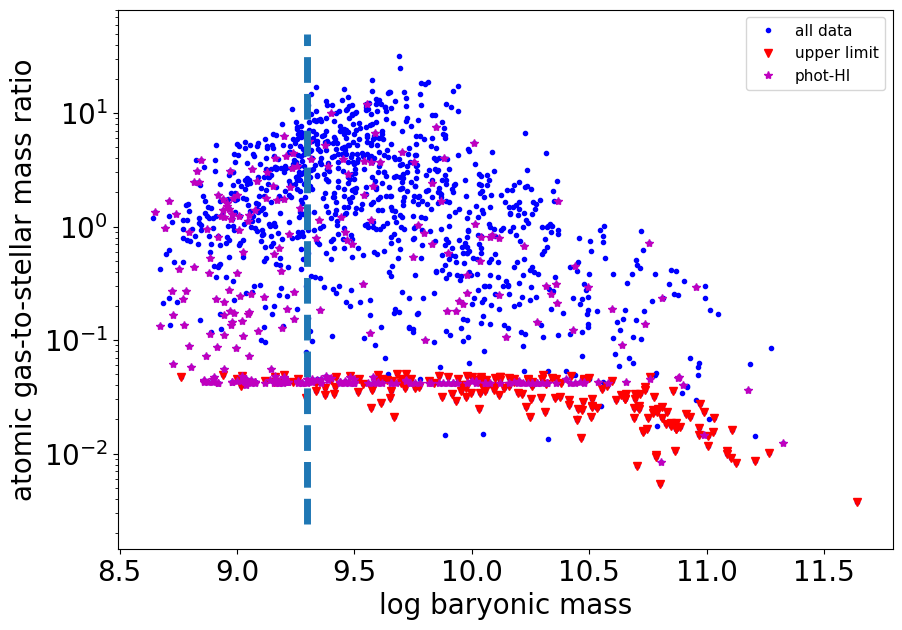

In [15]:
insample = inorigsample 
# for fun, could try looking at this in different halo mass regimes
#insample = inorigsample & (logmhalo >= 11.4) & (logmhalo < 12)
#insample = inorigsample & (logmhalo >= 12) & (logmhalo < 13.3)
selall = np.where(insample)
sellim = np.where(insample & stronglimit)
selfake = np.where(insample & fakedata)
#selcentral = np.where(insample & cent)

fig6 = plt.figure(6,figsize=(10,7))
plt.clf()
plt.plot(logmbary[selall],1.4*besthitostars[selall],'b.', label="all data")
plt.plot(logmbary[sellim],1.4*besthitostars[sellim],'rv', label="upper limit")
plt.plot(logmbary[selfake],1.4*besthitostars[selfake],'m*', label="phot-HI")
#plt.plot(logmbary[selcentral],1.4*besthitostars[selcentral],'gX', markerfacecolor=None, markersize=8, label="central")
plt.yscale('log')
plt.xlabel("log baryonic mass")
plt.ylabel("atomic gas-to-stellar mass ratio")
ylim = plt.ylim()
plt.vlines(9.3,ylim[0],ylim[1],linestyle="--",linewidth=5) # plot completeness limit
plt.legend(loc="best",fontsize=11)
plt.show()

### Notice RESOLVE has a LOT more HI data in the luminosity-complete sample than the baryonic mass-complete sample. This is due to the non-negligible scatter in baryonic mass-to-light ratio. There are even a few galaxies above the baryonic mass limit with luminosity below the original sample floor (picked up by our observational selection strategy, sample #2 defined at the top of this notebook).